# Matching and IPW tutorial

In [1]:
import numpy as np
from numpy.random import randn
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

import networkx as nx
import dowhy
import pandas as pd
from dowhy import CausalModel

style.use('fivethirtyeight') # bmh

import math
import dowhy.datasets, dowhy.plotter

import hyppo
import pingouin as pg
import conditional_independence

from hyppo.independence import Hsic

# the code below simple hides some warnings we don't want to see
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)


# a utility function to parse the .gml file to string
def gml_to_string(file):
    gml_str = ''
    with open(file, 'r') as file:
        for line in file:
            gml_str += line.rstrip()
    return gml_str

path = "/Users/dj/Documents/GitHub/Causal_Data_Science/Project/Data/lucas0_text/"
names = ['Smoking', 'Yellow_Fingers', 'Anxiety', 'Peer_Pressure', 'Genetics', 'Attention_Disorder','Born_an_Even_Day', 'Car_Accident', 'Fatigue', 'Allergy', 'Coughing']


# reading csv files
train =  pd.read_csv(path + 'lucas0_train.data', sep=" ", header = None)
train.drop(11, inplace = True, axis = 1)
train.columns = names
test =  pd.read_csv(path + 'lucas0_test.data', sep=" ", header = None)
test.drop(11, inplace = True, axis = 1)
test.columns = names
target =  pd.read_csv(path + 'lucas0_train.targets', sep=" ", header = None)
# param =  pd.read_csv(path + 'lucas0.param', sep=" ")

target[target[0] == -1] = 0

avgs = train[names].mean()

train["Lung_Cancer"] = np.array(target)

avgs = train.mean()


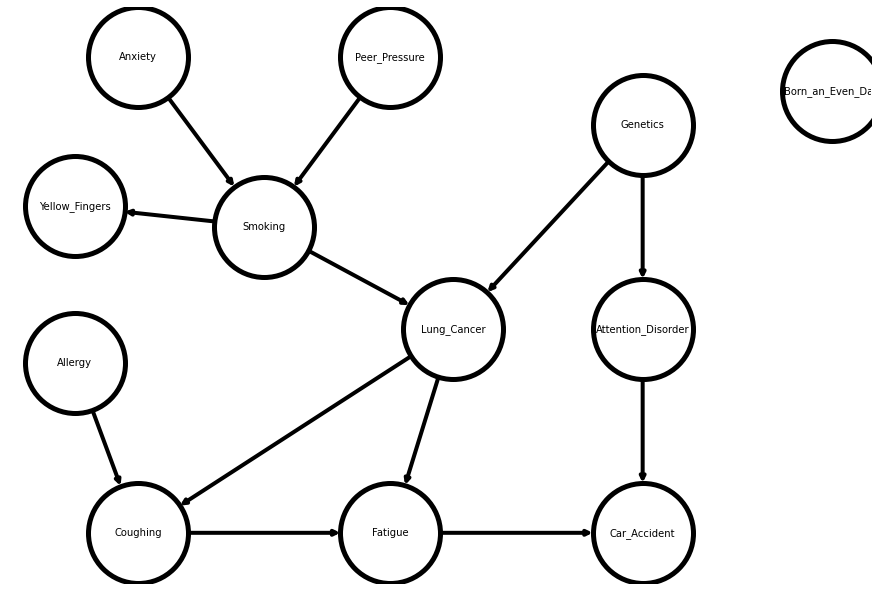

In [3]:
# we import networkx and create a directed graph
G = nx.DiGraph()

plt.figure(3,figsize=(12,8))

G.add_nodes_from(['Smoking', 'Yellow_Fingers', 'Anxiety', 'Peer_Pressure', 'Genetics', 'Attention_Disorder','Born_an_Even_Day', 'Car_Accident', 'Fatigue', 'Allergy', 'Coughing', 'Lung_Cancer'])

G.add_edges_from([('Anxiety','Smoking'), ('Peer_Pressure','Smoking'), ('Smoking','Yellow_Fingers'), ('Smoking','Lung_Cancer'), 
                  ('Allergy','Coughing'), ('Lung_Cancer','Coughing'), ('Coughing','Fatigue'), ('Lung_Cancer','Fatigue'),
                 ('Genetics','Lung_Cancer'), ('Genetics','Attention_Disorder'), ('Attention_Disorder', 'Car_Accident'), ('Fatigue', 'Car_Accident')])

# we can visualise this graph (choosing node positions, colours, and sizes to make it more clear) 
# and save it to a .gml format (for using DoWhy later)
pos = {'Anxiety': (-20, 40),              'Yellow_Fingers': (-25, 18),
         'Peer_Pressure': (0, 40), 'Smoking': (-10, 15), 'Allergy': (-25, -5),
         'Coughing': (-20, -30), 'Lung_Cancer': (5, 0), 'Genetics': (20, 30), 'Attention_Disorder': (20, 0),
         'Fatigue': (0, -30),'Car_Accident': (20, -30), 'Born_an_Even_Day' : (35,35)}

nx.draw(G, pos = pos,with_labels=True, node_size=10000, node_color='w', edgecolors ='black', linewidths= 5, width = 4, font_size = 10)
nx.write_gml(G, "backdoor_criterion_graph.gml")

plt.show()

We define a simulator for vaccine hesitancy data, where all variables are binary. X represents vaccine hesitancy, T if an individual gets vaccinated and Y if they recover.

In [4]:
def vaccine_hesitancy_SCM (remove_confounding=False, n_samples=1000):
    # X = vaccine hesitancy:
    # epsilon_x
    epsilon_x = np.random.choice(2, n_samples, p = [0.7, 0.3], replace = True)
    x = epsilon_x
    
    # T = get vaccinated:
    
    if remove_confounding:
        t = np.random.choice(2, n_samples, p = [0.5, 0.5], replace = True)
    else:
        # epsilon_t_0 = Ber(0.9):
        epsilon_t_0 = np.random.choice(2, n_samples, p = [0.1, 0.9], replace = True)
        # epsilon_t_1 = Ber(0.1):
        epsilon_t_1 = np.random.choice(2, n_samples, p = [0.9, 0.1], replace = True)
        # This is just a way to say that P(T|X=1) = P(epsilon_t_1) and P(T|X=0) = P(epsilon_t_0) 
        t = epsilon_t_1*x + epsilon_t_0*(1-x)
    
    # Y = recover
    # epsilons for all combinations of values for X and T
    # P(Y=1|X=0, T=0)= Ber(0.6)
    epsilon_y_00 = np.random.choice(2, n_samples, p = [0.4, 0.6], replace = True)
    # P(Y=1|X=0, T=1)= Ber(0.9)
    epsilon_y_01 = np.random.choice(2, n_samples, p = [0.1, 0.9], replace = True)
    # P(Y=1|X=1, T=0)= Ber(0.5)
    epsilon_y_10 = np.random.choice(2, n_samples, p = [0.5, 0.5], replace = True)
    # P(Y=1|X=1, T=1)= Ber(0.75)
    epsilon_y_11 = np.random.choice(2, n_samples, p = [0.25, 0.75], replace = True)
    
    # This is just a way to say that P(Y|X=0, T=0) = P(epsilon_y_00), P(Y|X=0, T=1) = P(epsilon_y_01) etc
    y = x*t*epsilon_y_11 + (1-x)*t*epsilon_y_01 + x*(1-t)*epsilon_y_10 + (1-x)*(1-t)*epsilon_y_00
    df = pd.DataFrame({ "x": x, "t": t, "y": y})
    return df

We start by simulating some observational data for vaccine hesitancy, in which people who are not hesitant are also engaging in other behaviours that might help them recover. We compute the Average Treatment Effect (ATE) with these data in a naive way:

In [3]:
# Simulate some observational data:
df = vaccine_hesitancy_SCM(n_samples=5000)

# Vaccinated people:
treatment_group = df[df["t"]==1]
# Non-vaccinated people:
control_group = df[df["t"]==0]

if len(treatment_group[treatment_group["x"]==1]) == 0 or len(treatment_group[treatment_group["x"]==0]) == 0:
    if len(control_group[control_group["x"]==1]) == 0 or len(control_group[control_group["x"]==0]) == 0:
        print("Positivity is violated, simulate more samples.")

ATE_biased = np.mean(treatment_group["y"]) - np.mean(control_group["y"])

print("ATE in observational data:", ATE_biased)

ATE in observational data: 0.3752997466444785


We now simulate some data without any confounding, e.g. what we would get by running a randomized control trial and randomly assigning people to get vaccinated or not. We then compute the Average Treatment Effect (ATE) with these data, which is an unbiased estimate of the real ATE:

In [10]:
df_rct = vaccine_hesitancy_SCM(n_samples=10000, remove_confounding=True)
# Vaccinated people:
treatment_group_rct = df_rct[df_rct["t"]==1]
# Non-vaccinated people:
control_group_rct = df_rct[df_rct["t"]==0]

ATE_rct = np.mean(treatment_group_rct["y"]) - np.mean(control_group_rct["y"])

print("ATE in an uncofounded setting (e.g. randomized controlled trial (RCT)):", ATE_rct, "(should be close to 0.3)")

ATE in an uncofounded setting (e.g. randomized controlled trial (RCT)): 0.2852229641224038 (should be close to 0.3)


We can see that the estimates for the ATEs are fairly different in the two settings (and we know the ATE in the RCT is supposed to be an approximation of the true ATE, which is close to 0.3), and that the ATE without correction overestimates the effect of the vaccine.

## Exact matching:

We can now conceptually pair each individual in the treatment group with $X=x$ with an individual in the control group with $X=x$, and remove the ones which don't match.

In [11]:
treatment_group_x_0 = treatment_group[treatment_group["x"]==0]
treatment_group_x_1 = treatment_group[treatment_group["x"]==1]

control_group_x_0 = control_group[control_group["x"]==0]
control_group_x_1 = control_group[control_group["x"]==1]

print("Number of people with X=0 in treatment: ", len(treatment_group_x_0)," and in control: ", len(control_group_x_0))
print("Number of people with X=1 in treatment: ", len(treatment_group_x_1)," and in control: ", len(control_group_x_1))

Number of people with X=0 in treatment:  3183  and in control:  332
Number of people with X=1 in treatment:  138  and in control:  1347


The numbers of people with X=0 and X=1 is quite unbalanced in the control and treatment.
We can also check covariate balancing on the original data P(X|T=0) should the same as P(X|T=1), or in finite data relatively close (we can use standardized mean difference to check how close they are in distribution). Since X is a binary variable, we can just check what happens for X=0

In [12]:
# approximating P(X=0|T=1)
freq_x0_treatment = len(treatment_group_x_0)/len(treatment_group)
# approximating P(X=0|T=0)
freq_x0_control = len(control_group_x_0)/len(control_group)
# In order to be balanced these two should be very close :
print("Proportion of X=0 on total in treatment: ", freq_x0_treatment, " and in control: ", freq_x0_control)

Proportion of X=0 on total in treatment:  0.9584462511291779  and in control:  0.197736748064324


We can now perform the matching. Since all units with X=x are conceptually the same, we don't need to actually match the pairs, but we can just keep the same number of people for treatment and control groups for each value of X=x.

In [13]:
min_number_x0 = min(len(treatment_group_x_0), len(control_group_x_0))
balanced_treatment_x_0 = treatment_group_x_0[0:min_number_x0]
balanced_control_x_0 = control_group_x_0[0:min_number_x0]
print("After balancing: number of people with X=0 in treatment: ", len(balanced_treatment_x_0)," and in control: ", len(balanced_control_x_0))

min_number_x1 = min(len(treatment_group_x_1), len(control_group_x_1))
balanced_treatment_x_1 = treatment_group_x_1[0:min_number_x1]
balanced_control_x_1 = control_group_x_1[0:min_number_x1]
print("After balancing: number of people with X=0 in treatment: ", len(balanced_treatment_x_1)," and in control: ", len(balanced_control_x_1))

After balancing: number of people with X=0 in treatment:  332  and in control:  332
After balancing: number of people with X=0 in treatment:  138  and in control:  138


We can now check again the covariate balancing and see that they are balanced and then just use this smaller dataset to estimate the ATE (which turns out to be closer to the true value than the original confounded case):

In [14]:
balanced_treatment = pd.concat([balanced_treatment_x_0, balanced_treatment_x_1])
balanced_control = pd.concat([balanced_control_x_1, balanced_control_x_0])

# approximating P(X=0|T=1)
freq_x0_treatment_matching = len(balanced_treatment_x_0)/len(balanced_treatment)
# approximating P(X=0|T=0)
freq_x0_control_matching = len(balanced_control_x_0)/len(balanced_control)
print("Proportion of X=0 on total in treatment: ", freq_x0_treatment_matching, " and in control: ", freq_x0_control_matching)

ATE_matching = np.mean(balanced_treatment["y"]) - np.mean(balanced_control["y"])
print("ATE after balancing:", ATE_matching)

Proportion of X=0 on total in treatment:  0.7063829787234043  and in control:  0.7063829787234043
ATE after balancing: 0.3191489361702128


We now used only one variable X for simplicity as the adjustment set. In general this method works also with more than one variable in the adjustment set, and if the variables are not discrete can also use a distance metric to match the units. Unfortunately, this method discared a lot of data, making the estimation less stable.

## Propensity scores:
We now compute $P(T=1|X)$ for each value of $X$:

In [15]:
x0_group = pd.concat([treatment_group_x_0,control_group_x_0])
x1_group = pd.concat([treatment_group_x_1,control_group_x_1])

propensity_score_x0 = len(treatment_group_x_0)/len(x0_group)
propensity_score_x1 = len(treatment_group_x_1)/len(x1_group)

print(propensity_score_x0, ": true value 0.9, ",  propensity_score_x1, ": true value 0.1")

0.905547652916074 : true value 0.9,  0.09292929292929293 : true value 0.1


We could do matching on the values of propensity scores (this is called propensity score matching), but in this case it doesn't really improve things since the probabilities are quite different for every combination of X. Otherwise it can be seen as a way of clustering values of X that have a similar effect on T.

## Inverse probability weighting

Instead we just use the formula to compute a weighted average for treatment and control:

In [17]:
number_of_all_samples = len(df)

weighted_sum_treatment_0 = sum(treatment_group_x_0["y"])/  propensity_score_x0
weighted_sum_treatment_1 = sum(treatment_group_x_1["y"])/ propensity_score_x1

mean_treatment = (weighted_sum_treatment_0 + weighted_sum_treatment_1) /number_of_all_samples

weighted_sum_control_0 = sum(control_group_x_0["y"])/(1 - propensity_score_x0)
weighted_sum_control_1 = sum(control_group_x_1["y"])/ (1 - propensity_score_x1)

mean_control = (weighted_sum_control_0 + weighted_sum_control_1)/number_of_all_samples

ATE_IPW = mean_treatment-mean_control
print("ATE after IPW:", ATE_IPW)

ATE after IPW: 0.3097862059781741


## Testing the mean and variance of the estimators

In [18]:
def IPW_XTY(df):
    # Vaccinated people:
    treatment_group = df[df["t"]==1]
    # Non-vaccinated people:
    control_group = df[df["t"]==0]
    
    number_of_all_samples = len(df)
    treatment_group_x_0 = treatment_group[treatment_group["x"]==0]
    treatment_group_x_1 = treatment_group[treatment_group["x"]==1]

    control_group_x_0 = control_group[control_group["x"]==0]
    control_group_x_1 = control_group[control_group["x"]==1]

    weighted_sum_treatment_0 = sum(treatment_group_x_0["y"])/  propensity_score_x0
    weighted_sum_treatment_1 = sum(treatment_group_x_1["y"])/ propensity_score_x1

    mean_treatment = weighted_sum_treatment_0 + weighted_sum_treatment_1
    mean_treatment = mean_treatment/number_of_all_samples

    weighted_sum_control_0 = sum(control_group_x_0["y"])/(1 - propensity_score_x0)
    weighted_sum_control_1 = sum(control_group_x_1["y"])/ (1 - propensity_score_x1)

    mean_control = weighted_sum_control_0 + weighted_sum_control_1 
    mean_control = mean_control/number_of_all_samples

    return mean_treatment-mean_control

def exactMatching_XTY(df):
    # Vaccinated people:
    treatment_group = df[df["t"]==1]
    # Non-vaccinated people:
    control_group = df[df["t"]==0]
    
    treatment_group_x_0 = treatment_group[treatment_group["x"]==0]
    treatment_group_x_1 = treatment_group[treatment_group["x"]==1]

    control_group_x_0 = control_group[control_group["x"]==0]
    control_group_x_1 = control_group[control_group["x"]==1]
    
    min_number_x0 = min(len(treatment_group_x_0), len(control_group_x_0))
    balanced_treatment_x_0 = treatment_group_x_0[0:min_number_x0]
    balanced_control_x_0 = control_group_x_0[0:min_number_x0]
    
    min_number_x1 = min(len(treatment_group_x_1), len(control_group_x_1))
    balanced_treatment_x_1 = treatment_group_x_1[0:min_number_x1]
    balanced_control_x_1 = control_group_x_1[0:min_number_x1]
    
    return np.mean(balanced_treatment["y"]) - np.mean(balanced_control["y"])

ATE_IPW_list = []
ATE_matching_list = []
ATE_rct_list = []


for i in range(0,100):
    df = vaccine_hesitancy_SCM(n_samples=5000)
    ATE_IPW_list.append(IPW_XTY(df))
    ATE_matching_list.append(exactMatching_XTY(df))
    df_rct = vaccine_hesitancy_SCM(n_samples=5000, remove_confounding=True)
    # Vaccinated people:
    treatment_group_rct = df_rct[df_rct["t"]==1]
    # Non-vaccinated people:
    control_group_rct = df_rct[df_rct["t"]==0]
    ATE_rct_list.append(np.mean(treatment_group_rct["y"]) - np.mean(control_group_rct["y"]))


print(np.mean(ATE_IPW_list), np.std(ATE_IPW_list), np.mean(ATE_matching_list), np.std(ATE_matching_list), np.mean(ATE_rct_list), np.std(ATE_rct_list))

0.27433145672010095 0.04028367535776573 0.31914893617021267 1.1102230246251565e-16 0.28427744151744727 0.011658471198446924


## Example with more variables:

In [23]:
def more_variables_SCM (remove_confounding=False, n_samples=1000):
    epsilon_x1 = np.random.choice(2, n_samples, p = [0.6, 0.4], replace = True)
    x1 = epsilon_x1
    
    epsilon_x2 = np.random.choice(2, n_samples, p = [0.7, 0.3], replace = True)
    x2 = epsilon_x2
    
    if remove_confounding:
        t = np.random.choice(2, n_samples, p = [0.5, 0.5], replace = True)
    else:
        epsilon_t_00 = np.random.choice(2, n_samples, p = [0.1, 0.9], replace = True)
        epsilon_t_10 = np.random.choice(2, n_samples, p = [0.8, 0.2], replace = True)
        epsilon_t_11 = np.random.choice(2, n_samples, p = [0.95, 0.05], replace = True)
        epsilon_t_01 = np.random.choice(2, n_samples, p = [0.7, 0.3], replace = True)    
        t = epsilon_t_00*(1-x1)*(1-x2) + epsilon_t_01*(1-x1)*x2 + epsilon_t_10*x1*(1-x2) + epsilon_t_11*x1*x2
    
    
    x = x1 * x2
    epsilon_y_00 = np.random.choice(2, n_samples, p = [0.4, 0.6], replace = True)
    epsilon_y_01 = np.random.choice(2, n_samples, p = [0.1, 0.9], replace = True)
    epsilon_y_10 = np.random.choice(2, n_samples, p = [0.5, 0.5], replace = True)
    epsilon_y_11 = np.random.choice(2, n_samples, p = [0.25, 0.75], replace = True)
    y = x*t*epsilon_y_11 + (1-x)*t*epsilon_y_01 + x*(1-t)*epsilon_y_10 + (1-x)*(1-t)*epsilon_y_00
    
    df = pd.DataFrame({ "x1": x1, "x2": x2, "t": t, "y": y})
    return df

# Simulate some observational data:
df2 = more_variables_SCM(n_samples=5000)

# Vaccinated people:
t_group = df2[df2["t"]==1]
# Non-vaccinated people:
c_group = df2[df2["t"]==0]

ATE_biased = np.mean(t_group["y"]) - np.mean(c_group["y"])
df2_rct = more_variables_SCM(n_samples=10000, remove_confounding=True)
# Vaccinated people:
t_rct = df2_rct[df2_rct["t"]==1]
# Non-vaccinated people:
c_rct = df2_rct[df2_rct["t"]==0]
print("ATE in an uncofounded setting (e.g. randomized controlled trial (RCT)):", np.mean(t_rct["y"]) - np.mean(c_rct["y"]), ", unadjusted ATE:", ATE_biased)

treatment_group_x_0 = t_group[t_group["x1"]==0]
treatment_group_x_1 = t_group[t_group["x1"]==1]

treatment_group_x_00 = treatment_group_x_0[treatment_group_x_0["x2"]==0]
treatment_group_x_10 = treatment_group_x_1[treatment_group_x_1["x2"]==0]
treatment_group_x_01 = treatment_group_x_0[treatment_group_x_0["x2"]==1]
treatment_group_x_11 = treatment_group_x_1[treatment_group_x_1["x2"]==1]

control_group_x_0 = c_group[c_group["x1"]==0]
control_group_x_1 = c_group[c_group["x1"]==1]

control_group_x_00 = control_group_x_0[control_group_x_0["x2"]==0]
control_group_x_10 = control_group_x_1[control_group_x_1["x2"]==0]
control_group_x_01 = control_group_x_0[control_group_x_0["x2"]==1]
control_group_x_11 = control_group_x_1[control_group_x_1["x2"]==1]


min_number_x_00 = min(len(treatment_group_x_00), len(control_group_x_00))
balanced_treatment_x_00 = treatment_group_x_00[0:min_number_x_00]
balanced_control_x_00 = control_group_x_00[0:min_number_x_00]
print("After balancing: number of people with X1=0 and X2=0 in treatment: ", len(balanced_treatment_x_00)," and in control: ", len(balanced_control_x_00))

min_number_x_01 = min(len(treatment_group_x_01), len(control_group_x_01))
balanced_treatment_x_01 = treatment_group_x_01[0:min_number_x_01]
balanced_control_x_01 = control_group_x_01[0:min_number_x_01]
print("After balancing: number of people with X1=0 and X2=1 in treatment: ", len(balanced_treatment_x_01)," and in control: ", len(balanced_control_x_01))

min_number_x_10 = min(len(treatment_group_x_10), len(control_group_x_10))
balanced_treatment_x_10 = treatment_group_x_10[0:min_number_x_10]
balanced_control_x_10 = control_group_x_10[0:min_number_x_10]
print("After balancing: number of people with X1=1 and X2=0 in treatment: ", len(balanced_treatment_x_10)," and in control: ", len(balanced_control_x_10))

min_number_x_11 = min(len(treatment_group_x_11), len(control_group_x_11))
balanced_treatment_x_11 = treatment_group_x_11[0:min_number_x_11]
balanced_control_x_11 = control_group_x_11[0:min_number_x_11]
print("After balancing: number of people with X1=1 and X2=1 in treatment: ", len(balanced_treatment_x_11)," and in control: ", len(balanced_control_x_11))


ATE in an uncofounded setting (e.g. randomized controlled trial (RCT)): 0.308437805039562 , unadjusted ATE: 0.3164534578836842
After balancing: number of people with X1=0 and X2=0 in treatment:  209  and in control:  209
After balancing: number of people with X1=0 and X2=1 in treatment:  286  and in control:  286
After balancing: number of people with X1=1 and X2=0 in treatment:  266  and in control:  266
After balancing: number of people with X1=1 and X2=1 in treatment:  31  and in control:  31


In [24]:
balanced_treatment2 = pd.concat([balanced_treatment_x_00, balanced_treatment_x_01, balanced_treatment_x_10, balanced_treatment_x_11])
balanced_control2 = pd.concat([balanced_control_x_01, balanced_control_x_00, balanced_control_x_11, balanced_control_x_10])

ATE_matching2 = np.mean(balanced_treatment2["y"]) - np.mean(balanced_control2["y"])
print("ATE after balancing:", ATE_matching2)

ATE after balancing: 0.31565656565656564


Exact matching discarded a lot of data, so the estimate is quite unstable. We now look quickly at propensity scores, which are again not very useful in this case, and then we look at inverse probability weighting which does not discard any data.

## Propensity scores

We now compute $P(T=1|X)$ for each value of $X$:

In [25]:
x00_group = pd.concat([treatment_group_x_00,control_group_x_00])
x10_group = pd.concat([treatment_group_x_10,control_group_x_10])
x01_group = pd.concat([treatment_group_x_01,control_group_x_01])
x11_group = pd.concat([treatment_group_x_11,control_group_x_11])

propensity_score_x00 = len(treatment_group_x_00)/len(x00_group)
propensity_score_x10 = len(treatment_group_x_10)/len(x10_group)
propensity_score_x01 = len(treatment_group_x_01)/len(x01_group)
propensity_score_x11 = len(treatment_group_x_11)/len(x11_group)

We could do matching on the values of propensity scores (this is called propensity score matching), but in this case it doesn't really improve things since the probabilities are quite different for every combination of X. Otherwise it can be seen as a way of clustering values of X that have a similar effect on T.

## Inverse probability weighting

In [26]:
number_of_all_samples = len(df2)

weighted_sum_treatment_00 = sum(treatment_group_x_00["y"])/  propensity_score_x00
weighted_sum_treatment_01 = sum(treatment_group_x_01["y"])/ propensity_score_x01
weighted_sum_treatment_10 = sum(treatment_group_x_10["y"])/ propensity_score_x10
weighted_sum_treatment_11 = sum(treatment_group_x_11["y"])/ propensity_score_x11

mean_treatment2 = weighted_sum_treatment_00 + weighted_sum_treatment_01 + weighted_sum_treatment_10 + weighted_sum_treatment_11
mean_treatment2 = mean_treatment2/number_of_all_samples

weighted_sum_control_00 = sum(control_group_x_00["y"])/(1 - propensity_score_x00)
weighted_sum_control_01 = sum(control_group_x_01["y"])/ (1 - propensity_score_x01)
weighted_sum_control_10 = sum(control_group_x_10["y"])/ (1 - propensity_score_x10)
weighted_sum_control_11 = sum(control_group_x_11["y"])/ (1 - propensity_score_x11)

mean_control2 = weighted_sum_control_00 + weighted_sum_control_01 + weighted_sum_control_10 + weighted_sum_control_11
mean_control2 = mean_control2/number_of_all_samples

ATE_IPW2 = mean_treatment2-mean_control2
print("ATE after IPW:", ATE_IPW2)

ATE after IPW: 0.3090427537425747
